<a href="https://colab.research.google.com/github/JayJaewonYoo/BrainTumorWSS_Superpixels/blob/main/training_inference_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Superpixel Generation and Clustering for Weakly Supervised Segmentation of Brain Tumors in MR Images
This notebook serves to demonstrate how to train and run the weakly supervised segmentation models propposed in the paper [Deep Superpixel Generation and Clustering for Weakly Supervised Segmentation of Brain Tumors in MR Images](https://arxiv.org/abs/2209.09930).

## Importing libraries

In [1]:
!pip install --upgrade --quiet gdown # Required otherwise large files cannot be downloaded

In [2]:
# Importing libraries
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
# from torchvision.utils import make_grid
import torchvision.models as models
import gdown

## Loading preprocessed example MR images from the [BraTS 2020 dataset](https://www.med.upenn.edu/cbica/brats2020/data.html),  corresponding seeds, and pretrained model weights.

In [3]:
gdown.download(f"https://drive.google.com/uc?id=1kAwbIDnbe9C7H7MH5120OVrACcpxUslo&confirm=t", "mr_images.pt")
gdown.download(f"https://drive.google.com/uc?id=1G6qUuzh4ZER_ATe73MFQe3OrOgsn-8Ou&confirm=t", "seeds.pt")
gdown.download(f"https://drive.google.com/uc?id=1V8zuZi4_AxkJV585PuVaI-W5oeJfa6G-&confirm=t", "pretrained_model_weights.pt")

Downloading...
From: https://drive.google.com/uc?id=1kAwbIDnbe9C7H7MH5120OVrACcpxUslo&confirm=t
To: /content/mr_images.pt
100%|██████████| 780M/780M [00:09<00:00, 79.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1G6qUuzh4ZER_ATe73MFQe3OrOgsn-8Ou&confirm=t
To: /content/seeds.pt
100%|██████████| 390M/390M [00:03<00:00, 122MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V8zuZi4_AxkJV585PuVaI-W5oeJfa6G-&confirm=t
To: /content/pretrained_model_weights.pt
100%|██████████| 177M/177M [00:03<00:00, 49.1MB/s]


'pretrained_model_weights.pt'

For demonstration purposes in this notebook only CPU is used. Use the commented code labeled GPU when running with a GPU available.

In [5]:
# mr_images = torch.load("mr_images.pt") # GPU
# seeds = torch.load("seeds.pt") # GPU
# pretrained_model_weights = torch.load("pretrained_model_weights.pt") # GPU
mr_images = torch.load("mr_images.pt", map_location=torch.device('cpu'))
seeds = torch.load("seeds.pt", map_location=torch.device('cpu'))
pretrained_model_weights = torch.load("pretrained_model_weights.pt", map_location=torch.device('cpu'))

## Defining data specifications

Each image must be of shape (1, 4, H, W), where H and W are 128. This is a single image example but datasets with N images would have shape (N, 4, H, W).

The 4 channels correspond to the following volumes in order:
1.   T2 Fluid Attenuated Inversion Recovery (T2-FLAIR)
2.   Native (T1)
3.   Post-contrast T1-weighted (T1Gd)
4.   T2-weighted (T2)

Details on the preprocessing can be found in the [paper](https://arxiv.org/abs/2209.09930).

Demonstrating the shape of a single sample.

In [17]:
print("Shape of a data sample:", mr_images.shape)

Shape of a data sample: torch.Size([1, 4, 128, 128])


Visualizing the preprocessed images.

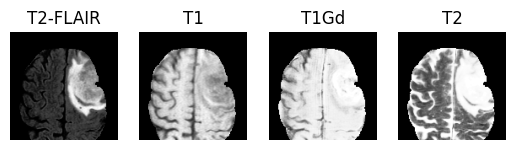

In [14]:
fig, axs = plt.subplots(1, 4)
channel_names = ["T2-FLAIR", "T1", "T1Gd", "T2"]
for channel_idx in range(4):
  axs[channel_idx].imshow(mr_images[0, channel_idx], cmap='gray')
  axs[channel_idx].set_title(channel_names[channel_idx])
  axs[channel_idx].axis('off')
plt.show()

The seeds were generated using [Randomized Input Sampling for Explanation of Black-box Models](https://arxiv.org/abs/1806.07421) from a classifier trained on binary image-level labels indicating whether or not the input images are cancerous. More details can be found in the [paper](https://arxiv.org/abs/2209.09930).

Each of the two channels are binary maps. The first channel corresponds to positive seeds (high likelihood of tumors). The second channel correspond to negative seeds (low likelihood of tumors).

Demonstrating the shape of the seeds for a single data sample.

In [18]:
print("Shape of seeds for a data sample:", seeds.shape)

Shape of seeds for a data sample: torch.Size([1, 2, 128, 128])


Visualizing the corresponding seeds (green: positive seeds, magenta: negative seeds, black: uncertain regions).

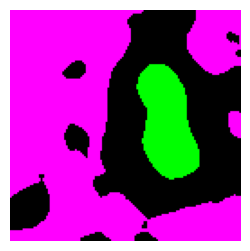

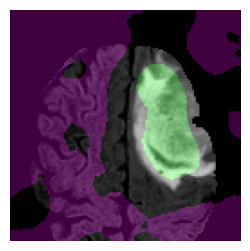

In [28]:
seed_visualization = torch.stack((seeds[0, 1], seeds[0, 0], seeds[0, 1]), dim=-1).type(torch.uint8) * 255
plt. figure(figsize=(3, 3))
plt.imshow(seed_visualization)
plt.axis('off')
plt.show()

plt. figure(figsize=(3, 3))
plt.imshow(mr_images[0, 0], cmap='gray')
plt.imshow(seed_visualization, alpha=0.25)
plt.axis('off')
plt.show()

## Defining Superpixel Generation Model Architecture
The architecture for the superpixel generation model is based on [AINet](https://arxiv.org/abs/2101.10696). Below is a custom implementation of the AINet architecture used for this work.

In [29]:
def convolution(in_channels, out_channels, kernel_size=3, stride=1, padding=1, output_padding=1, bias=True, batchnorm=True, activation='leaky_relu', transpose=False, softmax_dim=1):
    # Helper function to create convolution layer that maintains shape ith optional activation layer and batchnorm

    # Use stride = 1, kernel = 3, padding = 1 for convenience
    # Activation argument is one of 'relu', 'sigmoid', or 'none

    layers = []
    # Adding convolutional layer
    if not transpose:
        layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias and not batchnorm))
    else:
        layers.append(nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding, bias=bias))

    # Adding batchnorm
    if batchnorm:
        layers.append(nn.BatchNorm2d(out_channels))

    # Adding activation
    if activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'sigmoid':
        layers.append(nn.Sigmoid())
    elif activation == 'softmax':
        layers.append(nn.Softmax(dim=softmax_dim))
    elif activation == 'leaky_relu':
        layers.append(nn.LeakyReLU())
    elif activation == 'none':
        pass
    else:
        assert False, "Invalid activation function."

    return nn.Sequential(*layers)

def check_power_2(val):
    # Checks if input val is a power of 2

    return (val & (val - 1) == 0) and val != 0

class superpixel_generation_ainet(nn.Module):
    # Custom implementation of AINet architecture

    # Paper simply specifies an encoder-decoder style paradigm, the encoder module compresses the input
    # image and outputs a feature map called superpixel embedding, whose pixels exactly encode the features of grid cells.
    # The paper specifies the use of skip connections
        # For now, a variation of UNet using parts of AINet and Superpixel Embedding Networks paper will be used as the autoencoder
        # However, the autoencoder can be replaced with variations such as the asymmetric autoencoder
    # Had to choose between using same shape convolutions with max pooling or strided convolutions for encoding
        # Chose strided convolutions to try to better learn superpixel embeddings
    # Had to choose upsampling and transposed convolution
        # Chose transposed convolution to better learn how convert superpixel embeddings into pixel embeddings

    # Superpixel embeddings are acquired from output of encoder and pixel embeddings are acquired from output of decoder

    def __init__(self, S=16, in_channels=3, embed_channels=256, image_size=208):
        # S is the sampling interval
        # in_channels is the number of input channels, default 3 for RGB
            # different from D in that D is the channels of the pixel embeddings
        # superpixel_grid_size is the size of superpixel initial_seeds
        # image_size is size of spatial dims, assuming H == W
        # num_pixel features is the number of pixel features in the labels

        super().__init__()

        assert check_power_2(S), "S must be a power of 2."

        # Recommended to keep these this way because all calculations were done assuming these values
        self.default_kernel_size = 3
        default_padding = 1

        num_encode_decode_layers = np.log2(S).astype(int)
        self.D = embed_channels // (2 ** num_encode_decode_layers)
        self.image_size = image_size
        self.default_k = int(np.floor(self.default_kernel_size // 2))
        self.default_k_plus1 = self.default_k + 1
        self.grid_cell_size = S

        assert self.image_size % self.grid_cell_size == 0, "Image size must be divisable by S."

        # Autoencoder
        ########################################
        self.encode_layers = []
        self.encode_contract_layers = []
        self.skip_connection_ops = []

        # Encoding
        for layer_idx in range(0, num_encode_decode_layers):
            curr_channels = self.D * (2 ** layer_idx)
            next_channels = self.D * (2 ** (layer_idx + 1))
            self.encode_layers.append(
                nn.Sequential(
                    convolution(in_channels=in_channels if layer_idx == 0 else curr_channels,
                                out_channels=curr_channels,
                                kernel_size=self.default_kernel_size,
                                activation='relu',
                                batchnorm=True,
                                stride=1,
                                padding=default_padding),
                    convolution(in_channels=curr_channels,
                                out_channels=curr_channels,
                                kernel_size=self.default_kernel_size,
                                activation='relu',
                                batchnorm=True,
                                stride=1,
                                padding=default_padding),
                )
            )
            self.encode_contract_layers.append(
                    convolution(in_channels=curr_channels, # This convolution downsamples and increases channels
                                out_channels=next_channels,
                                kernel_size=self.default_kernel_size,
                                activation='relu',
                                batchnorm=True,
                                stride=2,
                                padding=default_padding)
            )
            self.skip_connection_ops.append(
                convolution(in_channels=curr_channels,
                           out_channels=curr_channels,
                            kernel_size=self.default_kernel_size,
                            activation='relu',
                            batchnorm=False,
                            stride=1,
                            padding=default_padding)
            )

        self.encode_layers = nn.ModuleList(self.encode_layers)
        self.encode_contract_layers = nn.ModuleList(self.encode_contract_layers)
        self.skip_connection_ops = nn.ModuleList(self.skip_connection_ops)

        # Decoding
        # Note that no batchnorm in the final decoding layer
        self.decode_layers = []
        for layer_idx in range(0, num_encode_decode_layers):
            curr_channels = embed_channels // (2 ** layer_idx)
            curr_channel_factor = 1 if layer_idx == 0 else 2
            next_channels = embed_channels // (2 ** (layer_idx + 1))
            self.decode_layers.append(
                nn.Sequential(
                    convolution(in_channels=curr_channels * curr_channel_factor,
                                out_channels=curr_channels,
                                kernel_size=self.default_kernel_size,
                                activation='relu',
                                batchnorm=True,
                                stride=1,
                                padding=default_padding),
                    convolution(in_channels=curr_channels,
                                out_channels=curr_channels,
                                kernel_size=self.default_kernel_size,
                                activation='relu',
                                batchnorm=True,
                                stride=1,
                                padding=default_padding),
                    convolution(in_channels=curr_channels, # This convolution downsamples and increases channels
                                out_channels=next_channels,
                                kernel_size=self.default_kernel_size,
                                activation='relu',
                                batchnorm=True,
                                stride=2,
                                padding=default_padding,
                                output_padding=2 - self.default_kernel_size + (2 * default_padding),
                                transpose=True)
                )
            )
        self.decode_layers = nn.ModuleList(self.decode_layers)

        # Final autoencoder layer
        self.final_autoencoder_layer = convolution(in_channels=self.D * 2,
                                out_channels=self.D,
                                kernel_size=self.default_kernel_size,
                                activation='relu',
                                batchnorm=False,
                                stride=1,
                                padding=default_padding)
        ########################################

        # Superpixel Embeddings Processing
        ########################################
        self.superpixel_embed_process_layers = []

        # Possibly replace this with a variable number of 2x upsample transpose convolutions because this can have
            # stride > kernel size which can cause potential problems. Since transposed convolutions still have the same
            # receptive field, it should be okay so long as it isn't one of the final output layers
        channel_processing_scales = [[i, embed_channels // self.D // i] for i in range(1, int(np.sqrt(embed_channels // self.D)) + 1) if embed_channels // self.D % i == 0][-1]
        shape_processing_scales = [[i, self.grid_cell_size // i] for i in range(1, int(np.sqrt(self.grid_cell_size)) + 1) if self.grid_cell_size % i == 0][-1]
            # Finds factors of grid cell size so that it doesn't have to be a square
        self.superpixel_embed_process_layers.append(
            convolution(in_channels=embed_channels, # This convolution downsamples and decreases channels
                    out_channels=embed_channels // channel_processing_scales[1],
                    kernel_size=self.default_kernel_size,
                    activation='relu',
                    batchnorm=True,
                    stride=shape_processing_scales[1],
                    padding=default_padding,
                    output_padding=shape_processing_scales[1] - self.default_kernel_size + (2 * default_padding),
                    transpose=True)
        )
        self.superpixel_embed_process_layers.append(
            convolution(in_channels=embed_channels // channel_processing_scales[1], # This convolution downsamples and decreases channels
                    out_channels=embed_channels // (channel_processing_scales[1] * channel_processing_scales[0]),
                    kernel_size = self.default_kernel_size,
                    activation='relu',
                    batchnorm=True,
                    stride=shape_processing_scales[0],
                    padding=default_padding,
                    output_padding=shape_processing_scales[0] - self.default_kernel_size + (2 * default_padding),
                    transpose=True)
        )
        self.superpixel_embed_process_layers = nn.ModuleList(self.superpixel_embed_process_layers)
        ########################################

        # Association Implantation Module
        ########################################
        pixel_embeds_kernel = torch.zeros(self.D, self.D, 3, 3)
        for idx in range(self.D):
            pixel_embeds_kernel[idx, idx, 1, 1] = 1

        # To send to cuda when model.cuda() is called
        self.register_buffer('pixel_embeds_kernel', pixel_embeds_kernel)
        self.pixel_embeds_kernel = dict(self.named_buffers())['pixel_embeds_kernel']

        # Using default_kernel_size as the stride here because paper states to distill superpixel embeddings for each pixel embedding individually
        self.implantation_distilling_conv = convolution (in_channels=self.D,
                                                         out_channels=self.D,
                                                         kernel_size=self.default_kernel_size,
                                                         activation='relu',
                                                         batchnorm=True,
                                                         stride=self.default_kernel_size,
                                                         padding=default_padding)
        ########################################

        # Final layer
        ########################################
        self.final_layer = convolution(in_channels=self.D,
                                out_channels=(self.image_size // self.grid_cell_size) ** 2,
                                kernel_size=self.default_kernel_size,
                                activation='softmax',
                                batchnorm=False,
                                stride=1,
                                padding=default_padding)
        ########################################

    def forward(self, x):

        # Autoencoder forward
        ##############################
        skip_connections = []
        for encode_idx in range(len(self.encode_layers)):
            x = self.encode_layers[encode_idx](x)
            skip_connections.append(x)
            x = self.encode_contract_layers[encode_idx](x)
        superpixel_embeddings = x
        for decode_idx, decode_layer in enumerate(self.decode_layers):
            skip_connection_idx = -1 - decode_idx
            x = torch.cat(
                (
                    decode_layer(x),
                    self.skip_connection_ops[skip_connection_idx](skip_connections[skip_connection_idx])
                ),
                1
            )
        # At this point, the number of channels should be 2*D and the first layer after this should change the layers to D
            # Note that D = 16 using default parameters
        pixel_embeddings = self.final_autoencoder_layer(x)
        ##############################

        # Superpixel embeddings processing
        ##############################
        original_superpixel_embeddings = superpixel_embeddings # Used for calculating ROI probabilities later
        for idx in range(2):
            superpixel_embeddings = self.superpixel_embed_process_layers[idx](superpixel_embeddings)
        ##############################

        # Association implantation module
        ############################### Calculating expanded superpixel embeddings
        superpixel_embeddings_pad = F.pad(superpixel_embeddings, (1, 1, 1, 1))

        pixel_embeddings_expanded = F.conv_transpose2d(pixel_embeddings, self.pixel_embeds_kernel, stride=self.default_kernel_size)

        # This line splits the padded superpixel embeddings into the patches that correspond to the expanded pixel embeddings
        superpixel_embeddings_patches = superpixel_embeddings_pad.unfold(2, self.default_kernel_size, 1).unfold(3, self.default_kernel_size, 1)

        # This code block rearranges the patches such that it matches the organization of the expanded pixel embeddings
        batch_size = superpixel_embeddings_patches.shape[0]

        superpixel_embeddings_patches = superpixel_embeddings_patches.contiguous().view(batch_size, self.D, -1, self.default_kernel_size ** 2)
        superpixel_embeddings_patches = superpixel_embeddings_patches.permute(0, 1, 3, 2)
        superpixel_embeddings_patches = superpixel_embeddings_patches.contiguous().view(batch_size, self.D * self.default_kernel_size ** 2, -1)
        superpixel_embeddings_expanded = F.fold(superpixel_embeddings_patches, output_size=pixel_embeddings_expanded.shape[2:], kernel_size=self.default_kernel_size, stride=self.default_kernel_size)

        pixel_superpixel_context = superpixel_embeddings_expanded + pixel_embeddings_expanded

        new_pixel_embeddings = self.implantation_distilling_conv(pixel_superpixel_context)
        ##############################

        # Getting association map
        ########################################
        association_map = self.final_layer(new_pixel_embeddings)
        ##############################

        return association_map

## Defining loss functions

In [34]:
# # Loss
# shift9pos, init_spixel_grid, and global_compute_semantic_pos_loss adapted from https://github.com/fuy34/superpixel_fcn

def shift9pos(input, h_shift_unit=1,  w_shift_unit=1):
    # input should be padding as (c, 1+ height+1, 1+width+1)
    input_pd = np.pad(input, ((h_shift_unit, h_shift_unit), (w_shift_unit, w_shift_unit)), mode='edge')
    input_pd = np.expand_dims(input_pd, axis=0)

    # assign to ...
    top     = input_pd[:, :-2 * h_shift_unit,          w_shift_unit:-w_shift_unit]
    bottom  = input_pd[:, 2 * h_shift_unit:,           w_shift_unit:-w_shift_unit]
    left    = input_pd[:, h_shift_unit:-h_shift_unit,  :-2 * w_shift_unit]
    right   = input_pd[:, h_shift_unit:-h_shift_unit,  2 * w_shift_unit:]

    center = input_pd[:,h_shift_unit:-h_shift_unit,w_shift_unit:-w_shift_unit]

    bottom_right    = input_pd[:, 2 * h_shift_unit:,   2 * w_shift_unit:]
    bottom_left     = input_pd[:, 2 * h_shift_unit:,   :-2 * w_shift_unit]
    top_right       = input_pd[:, :-2 * h_shift_unit,  2 * w_shift_unit:]
    top_left        = input_pd[:, :-2 * h_shift_unit,  :-2 * w_shift_unit]

    shift_tensor = np.concatenate([     top_left,    top,      top_right,
                                        left,        center,      right,
                                        bottom_left, bottom,    bottom_right], axis=0)
    return shift_tensor

def init_spixel_grid(batch_size, image_size, grid_cell_size):
    img_height, img_width = image_size, image_size

    # get spixel id for the final assignment
    n_spixl_h = int(np.floor(img_height / grid_cell_size))
    n_spixl_w = int(np.floor(img_width / grid_cell_size))

    spixel_height = int(img_height / (1. * n_spixl_h))
    spixel_width = int(img_width / (1. * n_spixl_w))

    spix_values = np.int32(np.arange(0, n_spixl_w * n_spixl_h).reshape((n_spixl_h, n_spixl_w)))
    spix_idx_tensor_ = shift9pos(spix_values)

    spix_idx_tensor =  np.repeat(
        np.repeat(spix_idx_tensor_, spixel_height,axis=1), spixel_width, axis=2)

    torch_spix_idx_tensor = torch.from_numpy(
                np.tile(spix_idx_tensor, (batch_size, 1, 1, 1))).type(torch.float)#.cuda()


    curr_img_height = int(np.floor(img_height))
    curr_img_width = int(np.floor(img_width))

    # pixel coord
    all_h_coords = np.arange(0, curr_img_height, 1)
    all_w_coords = np.arange(0, curr_img_width, 1)
    curr_pxl_coord = np.array(np.meshgrid(all_h_coords, all_w_coords, indexing='ij'))

    coord_tensor = np.concatenate([curr_pxl_coord[1:2, :, :], curr_pxl_coord[:1, :, :]])

    all_XY_feat = (torch.from_numpy(
        np.tile(coord_tensor, (batch_size, 1, 1, 1)).astype(np.float32)))#.cuda())

    return  torch_spix_idx_tensor, all_XY_feat

def global_compute_semantic_pos_loss(prob_in, labxy_feat, pos_weight = 0.3,  kernel_size=16, use_cuda=True):
    # pos weight originally 0.003

    # this wrt the slic paper who used sqrt of (mse)

    # rgbxy1_feat: B*4+2*H*W
    # output : B*9*H*w
    # NOTE: this loss is only designed for one level structure
    S = kernel_size
    m = pos_weight
    prob = prob_in.clone()

    b, c, h, w = labxy_feat.shape

    pooled_numerator = prob.unsqueeze(2) * labxy_feat.unsqueeze(1)
    pooled_numerator = pooled_numerator.sum(dim=(-1, -2))
    pooled_denominator = prob.sum(dim=(-1, -2)).unsqueeze(-1)
    pooled_labxy = pooled_numerator / pooled_denominator
    reconstr_feat = (prob.unsqueeze(2) * pooled_labxy.unsqueeze(-1).unsqueeze(-1)).sum(dim=1)

    loss_map = reconstr_feat[:,-2:,:,:] - labxy_feat[:,-2:,:,:]
    loss_col_map = reconstr_feat[:,:-2:,:,:] - labxy_feat[:,:-2,:,:]

    # self def cross entropy  -- the official one combined softmax
    loss_pos = (torch.linalg.norm(loss_map, dim=1).sum() / b) * (m / S)
    loss_col = torch.linalg.norm(loss_col_map, dim=1).sum() / b

    # from the original authors: empirically we find timing 0.005 tend to better performance
    loss_pos_sum = 0.005 * loss_pos
    loss_col_sum = 0.005 * loss_col

    loss_sum = loss_pos_sum + loss_col_sum

    return loss_sum, loss_pos_sum, loss_col_sum

# Variant of SEC (seed, expand, constrain) (https://github.com/akolesnikoff/SEC)
class SeedLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SeedLoss, self).__init__()

    def forward(self, segmentation, seed_labels, smooth=1):

        # Goal here is to match the seed labels, so the -1 multiplication is required
        log_mask = torch.clamp(torch.log(segmentation), min=-100) * seed_labels
        numerator = torch.sum(log_mask, dim=(-1, -2, -3))
        denominator = torch.sum(seed_labels, dim=(-1, -2, -3))
        seed_loss_batches = -1 * ((numerator + smooth) / (denominator + smooth))
        seed_loss = seed_loss_batches.mean()

        return seed_loss

## Training Example

Initiailizing the models for training.

In [31]:
superpixel_generation_model = superpixel_generation_ainet(in_channels=4, image_size=128, S=16) # Change image_size accordingly

superpixel_scoring_model = models.resnet18()
superpixel_scoring_model.conv1 = nn.Conv2d(4 + 64, 64, kernel_size=(7, 7), stride=(2, 2),padding=(3, 3), bias=False)
superpixel_scoring_model.fc = nn.Linear(512, 64)

Initialize loss functions.

In [38]:
spixelID, XY_feat_stack = init_spixel_grid(batch_size=1, image_size=128, grid_cell_size=16) # Batch size set to 1 for demonstration purposes
seed_loss_func = SeedLoss()
scores_softmax = nn.Softmax(dim=1)

Preparing training hyperparameters, dataset, optimizer, and scheduler.

In [44]:
# Training hyperparameters
num_epochs = 1 # For demonstration purposes
initial_learning_rate = 0.0005
batch_size = 1 # For demonstration purposes
use_cuda = False # For demonstration purposes
seed_loss_weight = 50

In [45]:
# Dataset
class BraTS_weaklysupervisedsuperpixelsegmentation_dataset(Dataset):
    def __init__(self, input_data, input_seeds):
        super().__init__()
        # data is (N, 4, H, W)
        # labels is (N, H, W)

        self.num_data = len(input_data)
        self.data = input_data
        self.seeds = input_seeds

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        return self.data[idx], self.seeds[idx]

BraTS_train_dataset = BraTS_weaklysupervisedsuperpixelsegmentation_dataset(mr_images, seeds)
BraTS_train_dataloader = DataLoader(BraTS_train_dataset, batch_size=batch_size, pin_memory=False, num_workers=0, drop_last=True, shuffle=True)

In [46]:
optimizer = torch.optim.Adam(lr=initial_learning_rate, params=list(superpixel_generation_model.parameters()) + list(superpixel_scoring_model.parameters()), weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs // 4, gamma=0.5)

In [48]:
for epoch in range(0, num_epochs):
    for batch, (data, ground_truths) in enumerate(BraTS_train_dataloader):
        labels = torch.cat([data, XY_feat_stack[:data.shape[0]]], dim=1)
        if use_cuda:
            data = data.cuda()
            labels = labels.cuda()
            ground_truths = ground_truths.cuda()

        association_map = superpixel_generation_model(data)

        superpixel_scoring_input = torch.cat((data, association_map), dim=1)
        superpixel_scores_logits = superpixel_scoring_model(superpixel_scoring_input)
        superpixel_scores = scores_softmax(superpixel_scores_logits)

        loss_total, loss_pos_sum, loss_col_sum = global_compute_semantic_pos_loss(association_map, labels, kernel_size=16, use_cuda=use_cuda) # 16 here is the grid cell size, which we set to 16 throughout this notebook and our experiments

        mask = association_map * superpixel_scores.view(superpixel_scores.shape[0], superpixel_scores.shape[1], 1, 1)
        mask = mask.sum(dim=1)
        mask = mask.view(mask.shape[0], 1, mask.shape[1], mask.shape[2])
        mask = torch.cat((mask, 1 - mask), dim=1)

        seed_loss = seed_loss_func(mask, ground_truths) * seed_loss_weight

        loss_total = loss_total + seed_loss

        optimizer.zero_grad(set_to_none=True)
        loss_total.backward()
        optimizer.step()

## Inference example

Loading model with pretrained weights for inference.

In [50]:
superpixel_generation_model = superpixel_generation_ainet(in_channels=4, image_size=128, S=16) # Change image_size accordingly
# superpixel_generation_model.load_state_dict(torch.load("pretrained_model_weights.pt")["model_state_dict"]) # GPU
superpixel_generation_model.load_state_dict(torch.load("pretrained_model_weights.pt", map_location=torch.device('cpu'))["model_state_dict"])
superpixel_generation_model.eval()

superpixel_scoring_model = models.resnet18()
superpixel_scoring_model.conv1 = nn.Conv2d(4 + 64, 64, kernel_size=(7, 7), stride=(2, 2),padding=(3, 3), bias=False)
superpixel_scoring_model.fc = nn.Linear(512, 64)
# superpixel_scoring_model.load_state_dict(torch.load("pretrained_model_weights.pt")["scoring_model_state_dict"]) # GPU
superpixel_scoring_model.load_state_dict(torch.load("pretrained_model_weights.pt", map_location=torch.device('cpu'))["scoring_model_state_dict"])
superpixel_scoring_model.eval()

ResNet(
  (conv1): Conv2d(68, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

## Predicting segmentation using weakly supervised segmentation models

In [52]:
threshold = 0.6 # Decision threshold
association_map = superpixel_generation_model(mr_images)
superpixel_scoring_input = torch.cat((mr_images, association_map), dim=1)
superpixel_scores = superpixel_scoring_model(superpixel_scoring_input)
mask = association_map * superpixel_scores.view(superpixel_scores.shape[0], superpixel_scores.shape[1], 1, 1)
mask = mask.sum(dim=1)
mask = nn.Sigmoid()(mask.detach().cpu())
mask = mask.numpy()
mask = cv2.GaussianBlur(mask,(7,7),cv2.BORDER_DEFAULT)
mask = torch.from_numpy(mask)
mask[mask > threshold] = 1
mask[mask <= threshold] = 0

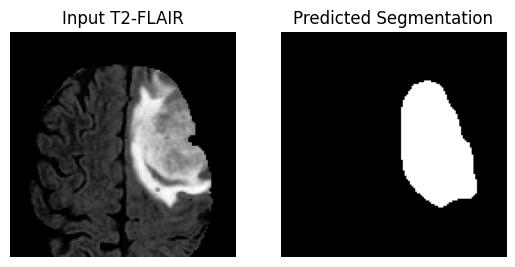

In [56]:
predicted_segmentation = mask[0]
fig, axs = plt.subplots(1, 2)
subplot_names = ["Input T2-FLAIR", "Predicted Segmentation"]
axs[0].imshow(mr_images[0, 0], cmap='gray')
axs[0].set_title("Input T2-FLAIR")
axs[0].axis('off')
axs[1].imshow(predicted_segmentation, cmap='gray')
axs[1].set_title("Predicted Segmentation")
axs[1].axis('off')
plt.show()